In [1]:
import numpy as np
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
pip install Folium

     |████████████████████████████████| 93 kB 2.5 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11685 sha256=f938e5a7394b4871b64b7d615e8e3933d6a768435bce6e6a168790353bb82c0b
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.


In [4]:
import wikipedia as wp

In [5]:
import folium

In [6]:
CLIENT_ID = '40GGT5GVNAEABKKBJFZORKHKXGHNTTXXVHM2S22YW1FQTGVR' # your Foursquare ID
CLIENT_SECRET = 'DG4WV3WP21FBLSNOHKFLW0EMXYYKKTVZGWM2ZLMLGNNCSFJK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 40GGT5GVNAEABKKBJFZORKHKXGHNTTXXVHM2S22YW1FQTGVR
CLIENT_SECRET:DG4WV3WP21FBLSNOHKFLW0EMXYYKKTVZGWM2ZLMLGNNCSFJK


In [7]:
chicago_data = pd.read_csv('https://data.cityofchicago.org/resource/kn9c-c2s2.csv')

In [8]:
chicago_data.drop(['ca', 'percent_of_housing_crowded', 'percent_households_below_poverty', 'percent_aged_16_unemployed', 'percent_aged_25_without_high_school_diploma', 'hardship_index'], axis=1, inplace=True)
chicago_data['latitude'] = ''
chicago_data['longitude'] = ''

In [9]:
chicago_data

,community_area_name,percent_aged_under_18_or_over_64,per_capita_income_,latitude,longitude
0,Rogers Park,27.5,23939,,
1,West Ridge,38.5,23040,,
2,Uptown,22.2,35787,,
3,Lincoln Square,25.5,37524,,
4,North Center,26.2,57123,,
...,...,...,...,...,...
73,Mount Greenwood,36.8,34381,,
74,Morgan Park,40.3,27149,,
75,O'Hare,30.3,25828,,
76,Edgewater,23.8,33385,,


In [10]:
for i, n in chicago_data.iterrows():
    print(str(i) + ' ' + n['community_area_name'])

0 Rogers Park
1 West Ridge
2 Uptown
3 Lincoln Square
4 North Center
5 Lake View
6 Lincoln Park
7 Near North Side
8 Edison Park
9 Norwood Park
10 Jefferson Park
11 Forest Glen
12 North Park
13 Albany Park
14 Portage Park
15 Irving Park
16 Dunning
17 Montclaire
18 Belmont Cragin
19 Hermosa
20 Avondale
21 Logan Square
22 Humboldt park
23 West Town
24 Austin
25 West Garfield Park
26 East Garfield Park
27 Near West Side
28 North Lawndale
29 South Lawndale
30 Lower West Side
31 Loop
32 Near South Side
33 Armour Square
34 Douglas
35 Oakland
36 Fuller Park
37 Grand Boulevard
38 Kenwood
39 Washington Park
40 Hyde Park
41 Woodlawn
42 South Shore
43 Chatham
44 Avalon Park
45 South Chicago
46 Burnside
47 Calumet Heights
48 Roseland
49 Pullman
50 South Deering
51 East Side
52 West Pullman
53 Riverdale
54 Hegewisch
55 Garfield Ridge
56 Archer Heights
57 Brighton Park
58 McKinley Park
59 Bridgeport
60 New City
61 West Elsdon
62 Gage Park
63 Clearing
64 West Lawn
65 Chicago Lawn
66 West Englewood
67 E

### Montclaire will be renamed "Monclare"
### Washington Height will be "Washington Heights"
### Final row is Chicago as a whole and needs to be dropped

In [11]:
chicago_data.at[17, 'community_area_name'] = 'Montclare'
chicago_data.at[72, 'community_area_name'] = 'Washington Heights'
chicago_data.drop(77, inplace=True)
for i, n in chicago_data.iterrows():
    print(str(i) + ' ' + n['community_area_name'])

0 Rogers Park
1 West Ridge
2 Uptown
3 Lincoln Square
4 North Center
5 Lake View
6 Lincoln Park
7 Near North Side
8 Edison Park
9 Norwood Park
10 Jefferson Park
11 Forest Glen
12 North Park
13 Albany Park
14 Portage Park
15 Irving Park
16 Dunning
17 Montclare
18 Belmont Cragin
19 Hermosa
20 Avondale
21 Logan Square
22 Humboldt park
23 West Town
24 Austin
25 West Garfield Park
26 East Garfield Park
27 Near West Side
28 North Lawndale
29 South Lawndale
30 Lower West Side
31 Loop
32 Near South Side
33 Armour Square
34 Douglas
35 Oakland
36 Fuller Park
37 Grand Boulevard
38 Kenwood
39 Washington Park
40 Hyde Park
41 Woodlawn
42 South Shore
43 Chatham
44 Avalon Park
45 South Chicago
46 Burnside
47 Calumet Heights
48 Roseland
49 Pullman
50 South Deering
51 East Side
52 West Pullman
53 Riverdale
54 Hegewisch
55 Garfield Ridge
56 Archer Heights
57 Brighton Park
58 McKinley Park
59 Bridgeport
60 New City
61 West Elsdon
62 Gage Park
63 Clearing
64 West Lawn
65 Chicago Lawn
66 West Englewood
67 En

In [12]:
for i, n in chicago_data.iterrows():
    address = '{}, Chicago'.format(n['community_area_name'])
    geolocator = Nominatim(user_agent="chi_explorer")
    location = geolocator.geocode(address)
    print(n['community_area_name'])
    chicago_data.at[i, 'latitude'] = location.latitude
    chicago_data.at[i, 'longitude'] = location.longitude

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


In [13]:
chicago_data

,community_area_name,percent_aged_under_18_or_over_64,per_capita_income_,latitude,longitude
0,Rogers Park,27.5,23939,42.0105,-87.6707
1,West Ridge,38.5,23040,42.0035,-87.6962
2,Uptown,22.2,35787,41.9666,-87.6555
3,Lincoln Square,25.5,37524,41.976,-87.6896
4,North Center,26.2,57123,41.9561,-87.6792
...,...,...,...,...,...
72,Washington Heights,42.6,19713,41.7064,-87.6562
73,Mount Greenwood,36.8,34381,41.6981,-87.7087
74,Morgan Park,40.3,27149,41.6903,-87.6667
75,O'Hare,30.3,25828,41.9731,-87.9068


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
chicago_venues = getNearbyVenues(names=chicago_data['community_area_name'],
                                   latitudes=chicago_data['latitude'],
                                   longitudes=chicago_data['longitude']
                                  )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


In [16]:
chicago_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.010531,-87.670748,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
1,Rogers Park,42.010531,-87.670748,Morse Fresh Market,42.008087,-87.667041,Grocery Store
2,Rogers Park,42.010531,-87.670748,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
3,Rogers Park,42.010531,-87.670748,The Common Cup,42.007797,-87.667901,Coffee Shop
4,Rogers Park,42.010531,-87.670748,Bark Place,42.010080,-87.675223,Pet Store
...,...,...,...,...,...,...,...
3936,Edgewater,41.983369,-87.663952,Wing Hoe,41.979918,-87.655033,Chinese Restaurant
3937,Edgewater,41.983369,-87.663952,Tedino's Pizzeria,41.979538,-87.654989,Pizza Place
3938,Edgewater,41.983369,-87.663952,Taketei Sushi,41.978093,-87.658353,Sushi Restaurant
3939,Edgewater,41.983369,-87.663952,Mei Shung,41.982098,-87.659987,Chinese Restaurant


In [17]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood'] 


# move neighborhood column to the first column
# fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
# chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot.pop('Neighborhood')
chicago_onehot.insert(0, 'Neighborhood', chicago_venues['Neighborhood'] )

chicago_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00
1,Archer Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.027027,0.000000,0.00
2,Armour Square,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.018182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00
3,Ashburn,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00
4,Auburn Gresham,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.064516,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,West Lawn,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00
73,West Pullman,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00
74,West Ridge,0.0,0.0,0.013514,0.0,0.0,0.0,0.0,0.027027,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.013514,0.00
75,West Town,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.01


In [19]:
chicago_sum = chicago_onehot.groupby('Neighborhood').sum().reset_index()
chicago_sum.drop(chicago_sum.columns.difference(['Neighborhood','Chinese Restaurant']), 1, inplace=True)
chicago_sum_existing = chicago_sum.drop(chicago_sum.loc[chicago_sum['Chinese Restaurant']==0].index)
chicago_sum

,Neighborhood,Chinese Restaurant
0,Albany Park,2
1,Archer Heights,0
2,Armour Square,10
3,Ashburn,1
4,Auburn Gresham,0
...,...,...
72,West Lawn,2
73,West Pullman,0
74,West Ridge,0
75,West Town,1


In [20]:
chicago_sum_existing.sort_values(by=['Chinese Restaurant'], ascending=False)

,Neighborhood,Chinese Restaurant
48,Near South Side,14
2,Armour Square,10
66,Uptown,4
10,Bridgeport,4
35,Jefferson Park,3
51,North Center,3
13,Calumet Heights,3
14,Chatham,3
34,Irving Park,2
72,West Lawn,2


In [21]:
chicago_grouped.shape

(77, 342)

In [22]:
num_top_venues = 10

for hood in chicago_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park----
                       venue  freq
0  Middle Eastern Restaurant  0.05
1         Mexican Restaurant  0.05
2          Korean Restaurant  0.04
3              Grocery Store  0.04
4                       Park  0.04
5                     Bakery  0.04
6             Ice Cream Shop  0.04
7                Pizza Place  0.04
8                 Donut Shop  0.03
9               Burger Joint  0.03


----Archer Heights----
                    venue  freq
0      Mexican Restaurant  0.14
1       Mobile Phone Shop  0.08
2           Grocery Store  0.05
3                    Food  0.05
4    Fast Food Restaurant  0.05
5      Recycling Facility  0.03
6                    Bank  0.03
7  Transportation Service  0.03
8              Shoe Store  0.03
9                  Bakery  0.03


----Armour Square----
                  venue  freq
0    Chinese Restaurant  0.18
1           Pizza Place  0.07
2                  Park  0.05
3                   Bar  0.05
4    Italian Restaurant  0.04
5         Groc

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Bakery,Ice Cream Shop,Park,Korean Restaurant,Pizza Place,Coffee Shop,Asian Restaurant
1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Food,Fast Food Restaurant,Grocery Store,Bar,Bank,Bakery,Arts & Crafts Store,Donut Shop
2,Armour Square,Chinese Restaurant,Pizza Place,Park,Bar,Mexican Restaurant,Grocery Store,Italian Restaurant,Business Service,Café,Hotel
3,Ashburn,Liquor Store,Fast Food Restaurant,Park,Clothing Store,Furniture / Home Store,Locksmith,Seafood Restaurant,Discount Store,Fried Chicken Joint,Gas Station
4,Auburn Gresham,Fast Food Restaurant,Pharmacy,Lounge,Park,American Restaurant,Discount Store,Bakery,Dive Bar,Basketball Court,Gas Station


In [25]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_merged = chicago_data
chicago_merged = chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='community_area_name')
chicago_merged.rename(columns={"community_area_name": "Neighborhood", "percent_aged_under_18_or_over_64": "% Under 18 and Above 64", "per_capita_income_":"Per Capita Income"}, inplace=True)
chicago_merged.head(35)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,27.5,23939,42.0105,-87.6707,1,Mexican Restaurant,Sandwich Place,Pizza Place,Bar,Bakery,Park,Sushi Restaurant,Beach,Theater,Café
1,West Ridge,38.5,23040,42.0035,-87.6962,1,Indian Restaurant,Pakistani Restaurant,Grocery Store,Fast Food Restaurant,Korean Restaurant,Park,Convenience Store,Bus Station,Bakery,Dessert Shop
2,Uptown,22.2,35787,41.9666,-87.6555,1,Vietnamese Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Bar,Thai Restaurant,Pizza Place,Park,Bakery,Sushi Restaurant
3,Lincoln Square,25.5,37524,41.976,-87.6896,1,Bar,Café,Sandwich Place,Pizza Place,Brewery,New American Restaurant,Liquor Store,Mexican Restaurant,Sushi Restaurant,Korean Restaurant
4,North Center,26.2,57123,41.9561,-87.6792,1,Bar,Pizza Place,Coffee Shop,Dive Bar,Mexican Restaurant,Pub,Thai Restaurant,Brewery,Chinese Restaurant,Yoga Studio
5,Lake View,17.0,60058,41.9471,-87.6554,1,General Entertainment,Coffee Shop,Pizza Place,Italian Restaurant,Sports Bar,Sandwich Place,Bar,Gay Bar,Taco Place,Mexican Restaurant
6,Lincoln Park,21.5,71551,41.9399,-87.6361,1,Harbor / Marina,Bar,Boat or Ferry,Gym,Mexican Restaurant,Coffee Shop,Gym / Fitness Center,Mediterranean Restaurant,Italian Restaurant,Athletics & Sports
7,Near North Side,22.6,88669,41.9,-87.6345,1,Hotel,Coffee Shop,Steakhouse,Gym,American Restaurant,Italian Restaurant,Gym / Fitness Center,Massage Studio,Bar,Yoga Studio
8,Edison Park,35.3,40959,42.0061,-87.814,1,Italian Restaurant,Park,Bar,Spa,Salon / Barbershop,Nail Salon,Theater,Pizza Place,Hot Dog Joint,Food & Drink Shop
9,Norwood Park,39.5,32875,41.9856,-87.8006,1,American Restaurant,Bar,Pizza Place,Park,Dog Run,Automotive Shop,Donut Shop,Clothing Store,Thai Restaurant,Sports Bar


In [46]:
address = 'Chicago, IL'
geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['latitude'], chicago_merged['longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
chicago_Chinese = chicago_merged.join(chicago_sum.set_index('Neighborhood'), on='Neighborhood')
chicago_Chinese.drop(chicago_Chinese.columns.difference(['Neighborhood','Chinese Restaurant', '% Under 18 and Above 64', 'Per Capita Income', 'Cluster Labels']), 1, inplace=True)
chicago_Chinese = chicago_Chinese.sort_values(by=['Chinese Restaurant'], ascending=False)
chicago_Chinese.head(35)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,Cluster Labels,Chinese Restaurant
32,Near South Side,21.8,59077,1,14
33,Armour Square,38.3,16148,1,10
2,Uptown,22.2,35787,1,4
59,Bridgeport,31.3,22694,1,4
4,North Center,26.2,57123,1,3
47,Calumet Heights,44.0,28887,3,3
10,Jefferson Park,35.5,27751,1,3
43,Chatham,40.3,18881,3,3
0,Rogers Park,27.5,23939,1,2
18,Belmont Cragin,37.3,15461,0,2


## Areas with Chinese Restaurants clearly fall into cluster 1

In [28]:
page = wp.page("Community_areas_in_Chicago").html().encode("UTF-8")
chicago_pop = pd.read_html(page)[0]
chicago_pop.rename(columns={'Name[8]':'Neighborhood', '2017[9]':'Population'}, inplace=True)
chicago_pop.drop(chicago_pop.columns.difference(['Neighborhood','Population']), 1, inplace=True)
chicago_pop.head(35)

,Neighborhood,Population
0,Rogers Park,55062
1,West Ridge,76215
2,Uptown,57973
3,Lincoln Square,41715
4,North Center,35789
5,Lake View,100470
6,Lincoln Park,67710
7,Near North Side,88893
8,Edison Park,11605
9,Norwood Park,37089


### The Loop's name needs to be adjusted

In [29]:
chicago_pop.at[31, 'Neighborhood'] = 'Loop'
chicago_pop.head(35)

,Neighborhood,Population
0,Rogers Park,55062
1,West Ridge,76215
2,Uptown,57973
3,Lincoln Square,41715
4,North Center,35789
5,Lake View,100470
6,Lincoln Park,67710
7,Near North Side,88893
8,Edison Park,11605
9,Norwood Park,37089


In [30]:
chicago_Chinese_population = chicago_Chinese.join(chicago_pop.set_index('Neighborhood'), on='Neighborhood')
chicago_Chinese_population.head(25)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,Cluster Labels,Chinese Restaurant,Population
32,Near South Side,21.8,59077,1,14,23620.0
33,Armour Square,38.3,16148,1,10,13455.0
2,Uptown,22.2,35787,1,4,57973.0
59,Bridgeport,31.3,22694,1,4,33637.0
4,North Center,26.2,57123,1,3,35789.0
47,Calumet Heights,44.0,28887,3,3,13188.0
10,Jefferson Park,35.5,27751,1,3,26808.0
43,Chatham,40.3,18881,3,3,31120.0
0,Rogers Park,27.5,23939,1,2,55062.0
18,Belmont Cragin,37.3,15461,0,2,79910.0


#### Since we are opening a high-end restaurant, we are not considering areas with under 40,000 in per capita income

In [31]:
chicago_Chinese_population = chicago_Chinese_population.drop(chicago_Chinese_population.loc[chicago_Chinese_population['Per Capita Income']<40000].index)

In [32]:
chicago_Chinese_population['Population Per Chinese Restaurant'] = ''
chicago_Chinese_population['Population Per Chinese Restaurant if Opened Here'] = ''
chicago_Chinese_population['Neighborhood Income Per Chinese Restaurant if Opened Here'] = ''
chicago_Chinese_population['Money in Target Age'] = ''
for i, n in chicago_Chinese_population.iterrows():
    try:
        chicago_Chinese_population.at[i, 'Population Per Chinese Restaurant'] = n['Population']/n['Chinese Restaurant']
    except:
        chicago_Chinese_population.at[i, 'Population Per Chinese Restaurant'] = 0
    chicago_Chinese_population.at[i, 'Population Per Chinese Restaurant if Opened Here'] = n['Population']/(n['Chinese Restaurant']+1)

In [33]:
chicago_Chinese_population

,Neighborhood,% Under 18 and Above 64,Per Capita Income,Cluster Labels,Chinese Restaurant,Population,Population Per Chinese Restaurant,Population Per Chinese Restaurant if Opened Here,Neighborhood Income Per Chinese Restaurant if Opened Here,Money in Target Age
32,Near South Side,21.8,59077,1,14,23620.0,1687.14,1574.67,,
4,North Center,26.2,57123,1,3,35789.0,11929.7,8947.25,,
6,Lincoln Park,21.5,71551,1,1,67710.0,67710,33855,,
8,Edison Park,35.3,40959,1,1,11605.0,11605,5802.5,,
23,West Town,21.7,43198,1,1,84502.0,84502,42251,,
7,Near North Side,22.6,88669,1,0,88893.0,0,88893,,
5,Lake View,17.0,60058,1,0,100470.0,0,100470,,
31,Loop,13.5,65526,1,0,35880.0,0,35880,,
11,Forest Glen,40.5,44164,1,0,19019.0,0,19019,,
27,Near West Side,22.2,44689,1,0,62872.0,0,62872,,


In [34]:
chicago_cluster1 = chicago_Chinese_population.drop(chicago_Chinese_population.loc[chicago_Chinese_population['Cluster Labels']!=1].index)
chicago_cluster1.sort_values(by=['Population Per Chinese Restaurant if Opened Here'], ascending=False)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,Cluster Labels,Chinese Restaurant,Population,Population Per Chinese Restaurant,Population Per Chinese Restaurant if Opened Here,Neighborhood Income Per Chinese Restaurant if Opened Here,Money in Target Age
5,Lake View,17.0,60058,1,0,100470.0,0,100470,,
7,Near North Side,22.6,88669,1,0,88893.0,0,88893,,
27,Near West Side,22.2,44689,1,0,62872.0,0,62872,,
23,West Town,21.7,43198,1,1,84502.0,84502,42251,,
31,Loop,13.5,65526,1,0,35880.0,0,35880,,
6,Lincoln Park,21.5,71551,1,1,67710.0,67710,33855,,
11,Forest Glen,40.5,44164,1,0,19019.0,0,19019,,
4,North Center,26.2,57123,1,3,35789.0,11929.7,8947.25,,
8,Edison Park,35.3,40959,1,1,11605.0,11605,5802.5,,
32,Near South Side,21.8,59077,1,14,23620.0,1687.14,1574.67,,


In [35]:
for i, n in chicago_Chinese_population.iterrows():
    chicago_Chinese_population.at[i, 'Neighborhood Income Per Chinese Restaurant if Opened Here'] = (n['Population Per Chinese Restaurant if Opened Here']*n['Per Capita Income'])

In [36]:
chicago_Chinese_population.sort_values(by=['Neighborhood Income Per Chinese Restaurant if Opened Here'], ascending=False)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,Cluster Labels,Chinese Restaurant,Population,Population Per Chinese Restaurant,Population Per Chinese Restaurant if Opened Here,Neighborhood Income Per Chinese Restaurant if Opened Here,Money in Target Age
7,Near North Side,22.6,88669,1,0,88893.0,0,88893,7.88205e+09,
5,Lake View,17.0,60058,1,0,100470.0,0,100470,6.03403e+09,
27,Near West Side,22.2,44689,1,0,62872.0,0,62872,2.80969e+09,
6,Lincoln Park,21.5,71551,1,1,67710.0,67710,33855,2.42236e+09,
31,Loop,13.5,65526,1,0,35880.0,0,35880,2.35107e+09,
23,West Town,21.7,43198,1,1,84502.0,84502,42251,1.82516e+09,
11,Forest Glen,40.5,44164,1,0,19019.0,0,19019,8.39955e+08,
4,North Center,26.2,57123,1,3,35789.0,11929.7,8947.25,5.11094e+08,
8,Edison Park,35.3,40959,1,1,11605.0,11605,5802.5,2.37665e+08,
32,Near South Side,21.8,59077,1,14,23620.0,1687.14,1574.67,9.30266e+07,


In [37]:
for i, n in chicago_Chinese_population.iterrows():
    chicago_Chinese_population.at[i, 'Money in Target Age'] = (1-(n['% Under 18 and Above 64']/100))*(n['Neighborhood Income Per Chinese Restaurant if Opened Here'])

In [38]:
chicago_Chinese_population.sort_values(by=['Money in Target Age'], ascending=False)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,Cluster Labels,Chinese Restaurant,Population,Population Per Chinese Restaurant,Population Per Chinese Restaurant if Opened Here,Neighborhood Income Per Chinese Restaurant if Opened Here,Money in Target Age
7,Near North Side,22.6,88669,1,0,88893.0,0,88893,7.88205e+09,6.10071e+09
5,Lake View,17.0,60058,1,0,100470.0,0,100470,6.03403e+09,5.00824e+09
27,Near West Side,22.2,44689,1,0,62872.0,0,62872,2.80969e+09,2.18594e+09
31,Loop,13.5,65526,1,0,35880.0,0,35880,2.35107e+09,2.03368e+09
6,Lincoln Park,21.5,71551,1,1,67710.0,67710,33855,2.42236e+09,1.90155e+09
23,West Town,21.7,43198,1,1,84502.0,84502,42251,1.82516e+09,1.4291e+09
11,Forest Glen,40.5,44164,1,0,19019.0,0,19019,8.39955e+08,4.99773e+08
4,North Center,26.2,57123,1,3,35789.0,11929.7,8947.25,5.11094e+08,3.77187e+08
8,Edison Park,35.3,40959,1,1,11605.0,11605,5802.5,2.37665e+08,1.53769e+08
32,Near South Side,21.8,59077,1,14,23620.0,1687.14,1574.67,9.30266e+07,7.27468e+07


In [39]:
final = chicago_Chinese_population.drop(chicago_Chinese_population.columns.difference(['Neighborhood','Money in Target Age']), 1).sort_values(by=['Money in Target Age'], ascending=False).head(5)

In [40]:
final

,Neighborhood,Money in Target Age
7,Near North Side,6.10071e+09
5,Lake View,5.00824e+09
27,Near West Side,2.18594e+09
31,Loop,2.03368e+09
6,Lincoln Park,1.90155e+09


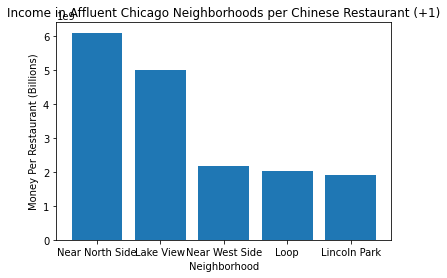

In [41]:
plt.bar(final['Neighborhood'], final['Money in Target Age'])
plt.title('Income in Affluent Chicago Neighborhoods per Chinese Restaurant (+1)')
plt.xlabel('Neighborhood')
plt.ylabel('Money Per Restaurant (Billions)')
# plt.rcParams['figure.figsize'] = (10,6)
plt.show()

In [42]:
chicago_cluster0 = chicago_merged.drop(chicago_merged.loc[chicago_merged['Cluster Labels']!=0].index)
chicago_cluster0.head(15)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Belmont Cragin,37.3,15461,41.9317,-87.7687,0,Mexican Restaurant,Sandwich Place,Pharmacy,Donut Shop,Currency Exchange,Discount Store,Breakfast Spot,Bank,Mobile Phone Shop,Fast Food Restaurant
19,Hermosa,36.4,15089,41.9286,-87.7345,0,Mexican Restaurant,Grocery Store,Pharmacy,Pizza Place,Discount Store,Park,Diner,Cuban Restaurant,Mobile Phone Shop,Storage Facility
29,South Lawndale,33.8,10402,41.8436,-87.7126,0,Mexican Restaurant,Fast Food Restaurant,Bank,Mobile Phone Shop,Taco Place,Dessert Shop,Nightclub,Ice Cream Shop,Plaza,Bus Station
30,Lower West Side,32.6,16444,41.8542,-87.6656,0,Mexican Restaurant,Pizza Place,Bar,Bakery,Latin American Restaurant,Park,Grocery Store,Art Gallery,Dessert Shop,Donut Shop
45,South Chicago,41.1,16579,41.7346,-87.5513,0,Mexican Restaurant,Grocery Store,Pharmacy,Discount Store,Sandwich Place,Donut Shop,Fish Market,Fast Food Restaurant,Shoe Store,Bank
56,Archer Heights,39.2,16134,41.8114,-87.7262,0,Mexican Restaurant,Mobile Phone Shop,Food,Fast Food Restaurant,Grocery Store,Bar,Bank,Bakery,Arts & Crafts Store,Donut Shop
57,Brighton Park,39.3,13089,41.8189,-87.6989,0,Taco Place,Donut Shop,Sandwich Place,Grocery Store,Mexican Restaurant,Ice Cream Shop,Seafood Restaurant,Café,Gym,Clothing Store
60,New City,38.9,12765,41.8075,-87.6564,0,Mexican Restaurant,Discount Store,Bank,Pharmacy,Grocery Store,American Restaurant,Brewery,Sporting Goods Shop,Athletics & Sports,Farm
61,West Elsdon,37.7,15754,41.7939,-87.7245,0,Mexican Restaurant,Pizza Place,Grocery Store,Pharmacy,Seafood Restaurant,Sandwich Place,Chinese Restaurant,Gas Station,Bank,Discount Store
62,Gage Park,38.8,12171,41.795,-87.6962,0,Mexican Restaurant,Grocery Store,Convenience Store,Dessert Shop,Taco Place,Sandwich Place,Coffee Shop,Video Store,Pharmacy,Park


In [43]:
chicago_cluster2 = chicago_merged.drop(chicago_merged.loc[chicago_merged['Cluster Labels']!=2].index)
chicago_cluster2.head(15)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Riverdale,51.5,8201,41.6678,-87.605,2,Martial Arts School,Train Station,Clothing Store,Fast Food Restaurant,Event Service,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm


In [44]:
chicago_cluster3 = chicago_merged.drop(chicago_merged.loc[chicago_merged['Cluster Labels']!=3].index)
chicago_cluster3.head(15)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Humboldt park,38.0,13781,41.9008,-87.724,3,Park,Music Venue,Donut Shop,Storage Facility,Snack Place,Seafood Restaurant,Convenience Store,Discount Store,Post Office,Thrift / Vintage Store
24,Austin,37.9,15957,41.8879,-87.7649,3,BBQ Joint,Fried Chicken Joint,Sandwich Place,Seafood Restaurant,Park,Grocery Store,Train Station,Gymnastics Gym,Discount Store,American Restaurant
25,West Garfield Park,43.6,10934,41.8806,-87.7292,3,Fast Food Restaurant,Shoe Store,Train Station,Fried Chicken Joint,Sandwich Place,ATM,Seafood Restaurant,Gas Station,Middle Eastern Restaurant,Supermarket
26,East Garfield Park,43.2,12961,41.8809,-87.7028,3,Food,Train Station,Art Gallery,Pharmacy,Diner,Sports Bar,Seafood Restaurant,Bakery,Event Service,Garden Center
28,North Lawndale,42.7,12034,41.86,-87.7184,3,Fast Food Restaurant,Sandwich Place,Food,Discount Store,Food Truck,Fried Chicken Joint,Burrito Place,Mobile Phone Shop,Café,Seafood Restaurant
34,Douglas,30.7,23791,41.8349,-87.618,3,Sandwich Place,Park,Fast Food Restaurant,Shipping Store,Wings Joint,Fried Chicken Joint,Bus Station,Historic Site,Bank,Pizza Place
35,Oakland,40.4,19252,41.8241,-87.6051,3,Park,Beach,BBQ Joint,Grocery Store,Performing Arts Venue,Art Gallery,Restaurant,Fried Chicken Joint,Bike Rental / Bike Share,Outdoor Sculpture
36,Fuller Park,44.9,10432,41.8181,-87.6326,3,Park,Food,Bus Station,Fast Food Restaurant,Pizza Place,Baseball Field,Sandwich Place,Train Station,Restaurant,Burger Joint
37,Grand Boulevard,39.5,23472,41.8139,-87.6173,3,BBQ Joint,Coffee Shop,Train Station,Discount Store,Deli / Bodega,Fast Food Restaurant,Bus Station,Liquor Store,Seafood Restaurant,Art Gallery
38,Kenwood,35.4,35911,41.8091,-87.598,3,Bus Station,Grocery Store,Park,Deli / Bodega,Fried Chicken Joint,Discount Store,Restaurant,BBQ Joint,Laundromat,Clothing Store


In [45]:
chicago_cluster4 = chicago_merged.drop(chicago_merged.loc[chicago_merged['Cluster Labels']!=4].index)
chicago_cluster4.head(15)

,Neighborhood,% Under 18 and Above 64,Per Capita Income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,South Deering,39.5,14685,41.6922,-87.5717,4,Bike Trail,Golf Course,Waste Facility,Park,Yoga Studio,Fast Food Restaurant,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant
